This notebook is a basic algorithm to demonstrate the possibility to downscale a national logistical function to a regional level, even with a lack of data points at the regional level.

The problem that we often face is that, in one hand, we have a temporal data at the national level which can be fitted as a logistic function (as the number of cars per capita, or the number of housing m2, etc.), but on the other hand, we have the data at one year at the regional level.

Thus, the question is how to fuse a temporal-national dataset with a spatial-regional one ?

Here we show that we can infer regional logistical functions with only one data point at the regional level by an optimization method that tries to reproduce the national curve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from functools import partial

In [2]:
np.random.seed(21)

In [3]:
rng = np.random.default_rng(42)  # Create a reproducible random generator

In [4]:
colors_reg = ["blue", "orange", "green",
    "peru", "darkorange", "gold", "purple", "magenta", "chartreuse", "turquoise", "darkcyan", "deepskyblue", 
     "brown",]

In [5]:
# definition of the 3 logistical parameters
k = 0.1 # the rate
s = 50  # the saturation
x0 = 50 # the inflection point

nb_vars = 3 # the number of variables to fit, here 3

# x is our "temporal" variable. It can serve either as time or as GDP/cap
x = np.linspace(0, 100)

In [6]:
def logistic(x, s, k, x0):
    return s / (1 + np.exp(-k*(x-x0)))

In [7]:
nb_reg = 3 # number of regions
nb_points = 1 # number of data points per function

# randomly distribute the population over the regions
population_ = rng.integers(1, 10, size=nb_reg).tolist()

# definition of the ratio of the population of the two regions. The sum must be 1
alpha_ = population_/np.sum(population_)

regional_logistics_ = []
national_logistic = np.zeros_like(x)
data_x_ = []
data_y_ = []

for i in range(nb_reg):
    y = logistic(x, rng.normal(s, 10), max( 0.05, rng.normal(k, .05)), rng.normal(x0, 10))
    regional_logistics_.append(y)

    point_x_ = []
    point_y_ = []
    for ii in range(nb_points):
        _idx = rng.integers(15, len(x)-10)
        point_x_.append(x[_idx])
        point_y_.append(y[_idx])

    data_x_.append(point_x_)
    data_y_.append(point_y_)
    national_logistic += alpha_[i]*y

In [8]:
def objective(vars):
    # y_true = logistic(x, s, k, x0)
    y_true = national_logistic
    y_pred = np.zeros_like(y_true)  # Initialize as array instead of list
    
    for idx in range(nb_reg):
        y_pred += alpha_[idx]*logistic(x, vars[idx*nb_vars], vars[idx*nb_vars+1], vars[idx*nb_vars+2])
  
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [9]:
def constraint_datapoint(vars, subregion_idx=0, point_idx=0):
    return logistic(data_x_[subregion_idx][point_idx], vars[subregion_idx*nb_vars+0], vars[subregion_idx*nb_vars+1], vars[subregion_idx*nb_vars+2]) - data_y_[subregion_idx][point_idx]  

The situation is the following : 

[]

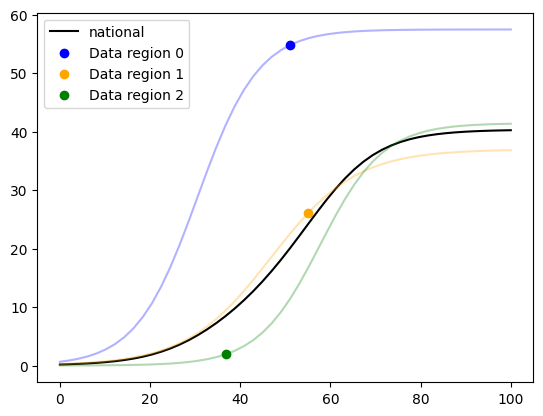

In [10]:
plt.plot(x, national_logistic, color="k", label="national")

for i in range(nb_reg):
    plt.scatter(data_x_[i], data_y_[i], color=colors_reg[i], label=f"Data region {i}")
    plt.plot(x, regional_logistics_[i], color=colors_reg[i], alpha=0.3)

plt.legend()
plt.plot()

Now we can optimize

In [11]:
# Combine the constraints
constraints = []

for i in range(nb_reg):
    for ii in range(nb_points):
        constraints.append({'type': 'eq', 'fun': partial(constraint_datapoint, subregion_idx=i, point_idx=ii)})

In [12]:
# Initial guess
initial_guess = [s, k, x0] * nb_reg

bounds = [(0, None), (0, None), (0, None)] * nb_reg

# Perform the optimization
opt = minimize(objective, initial_guess, bounds=bounds, constraints=constraints, method="SLSQP",)

# Display the opt
if opt.success:
    print("Optimal solution:", opt.x)
    print("Objective function value:", opt.fun)
else:
    print("Optimization failed:", opt.message)

Optimal solution: [54.82522942 27.45692826 42.86653597 32.27036223  0.09644055 40.0825134
 47.63292791  0.14276854 58.96921648]
Objective function value: 0.5292856248473174


/tmp/ipykernel_4117539/1665365677.py:2: RuntimeWarning: overflow encountered in exp
  return s / (1 + np.exp(-k*(x-x0)))


Plot the results

/tmp/ipykernel_4117539/1665365677.py:2: RuntimeWarning: overflow encountered in exp
  return s / (1 + np.exp(-k*(x-x0)))


[]

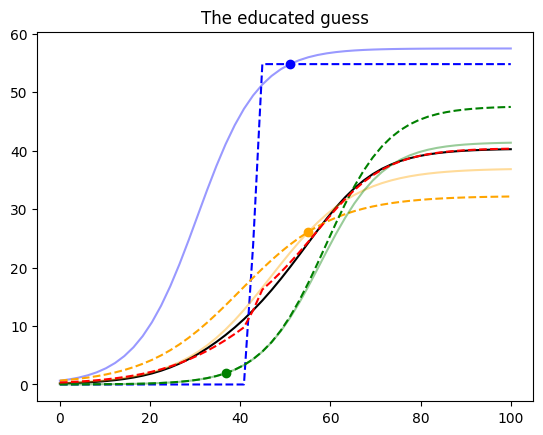

In [13]:
guessed_logistic = np.zeros_like(x)  # Initialize as array instead of list

plt.title("The educated guess")
# plt.plot(x, logistic(x, s, k, x0), color="k", label="national")
plt.plot(x, national_logistic, color="k", label="national")

for i in range(nb_reg):
    plt.scatter(data_x_[i], data_y_[i], color=colors_reg[i], ) #label=f"Data region {i}")
    plt.plot(x, logistic(x, opt.x[nb_vars*i+0], opt.x[nb_vars*i+1], opt.x[nb_vars*i+2]), color=colors_reg[i], linestyle="dashed", label=f"Estimated regional logistic {i}")
    plt.plot(x, regional_logistics_[i], color=colors_reg[i], alpha=0.4)
    guessed_logistic += alpha_[i] * logistic(x, opt.x[nb_vars*i+0], opt.x[nb_vars*i+1], opt.x[nb_vars*i+2])

plt.plot(x, guessed_logistic, color="r", label="fit", linestyle="dashed")
# plt.legend(loc="upper left")
plt.plot()

In [14]:
population_

[1, 7, 6]

/tmp/ipykernel_4117539/1665365677.py:2: RuntimeWarning: overflow encountered in exp
  return s / (1 + np.exp(-k*(x-x0)))


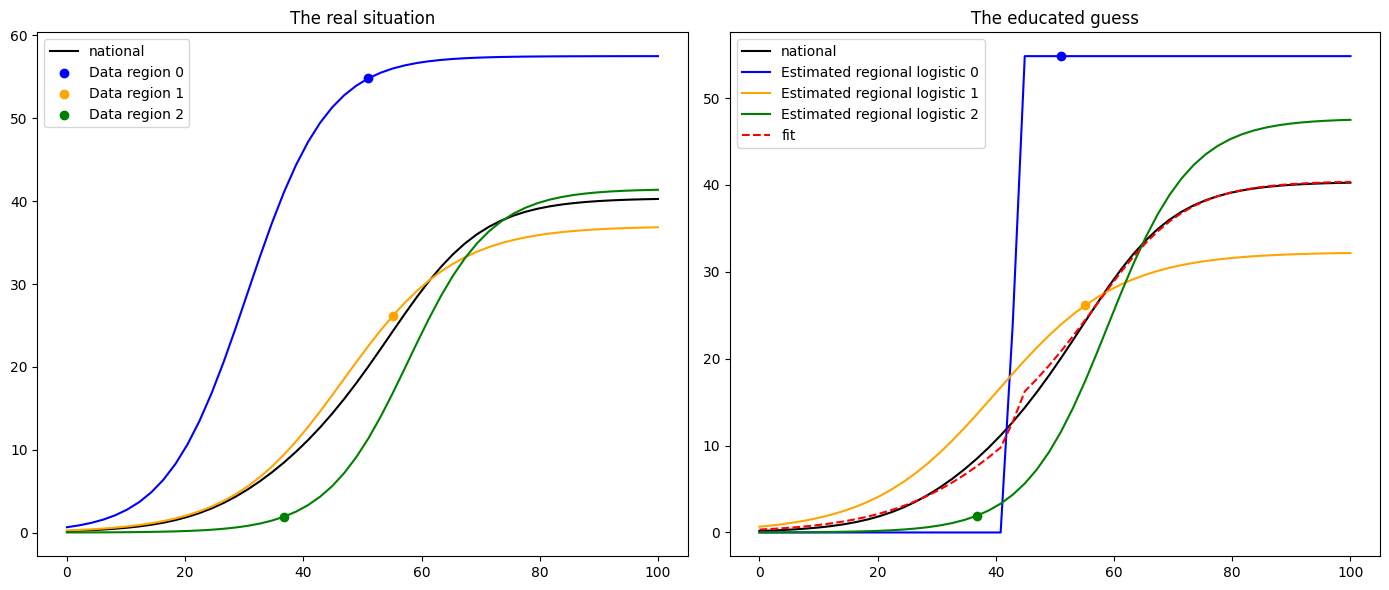

In [15]:
# Assuming necessary variables like x, nb_reg, etc. are defined

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns of plots

# First Plot: "The real situation"
axes[0].set_title("The real situation")
axes[0].plot(x, national_logistic, color="k", label="national")

for i in range(nb_reg):
    axes[0].scatter(data_x_[i], data_y_[i], color=colors_reg[i], label=f"Data region {i}")
    axes[0].plot(x, regional_logistics_[i], color=colors_reg[i])

axes[0].legend()

# Second Plot: "The educated guess"
guessed_logistic = np.zeros_like(x)  # Initialize as array instead of list
axes[1].set_title("The educated guess")
axes[1].plot(x, national_logistic, color="k", label="national")

for i in range(nb_reg):
    axes[1].scatter(data_x_[i], data_y_[i], color=colors_reg[i])  # Removed label for scatter
    axes[1].plot(
        x,
        logistic(x, opt.x[nb_vars * i + 0], opt.x[nb_vars * i + 1], opt.x[nb_vars * i + 2]),
        color=colors_reg[i],
        label=f"Estimated regional logistic {i}",
    )
    guessed_logistic += alpha_[i] * logistic(
        x, opt.x[nb_vars * i + 0], opt.x[nb_vars * i + 1], opt.x[nb_vars * i + 2]
    )

axes[1].plot(x, guessed_logistic, color="r", label="fit", linestyle="dashed")
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
